# <font color = 'green'> Nearest relation workbook: GB Only 

#### Documentation: Notebook assessing referenced location data to UK Postcode data
   - Distance to ref
   - Referenced index
   - Referenced postcode
   - Count of referenced locations within specified radius of postcode centroid
   - Weighted count
   
#### Author: Alex Armstrong
#### Created: 06/2022
#### Version: 0.1

## <font color = 'green'> Set up workbook

In [1]:
!python -m pip install adlfs
!pip install geopandas
!pip install adlfs
!pip install pygeos
!pip install rtree

^C
Traceback (most recent call last):
  File "/opt/conda/bin/pip", line 6, in <module>
    from pip._internal.cli.main import main
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/main.py", line 8, in <module>
    from pip._internal.cli.autocompletion import autocomplete
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/autocompletion.py", line 9, in <module>
    from pip._internal.cli.main_parser import create_main_parser
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/main_parser.py", line 7, in <module>
    from pip._internal.cli import cmdoptions
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/cmdoptions.py", line 22, in <module>
    from pip._internal.cli.progress_bars import BAR_TYPES
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/cli/progress_bars.py", line 9, in <module>
    from pip._internal.utils.logging import get_indentation
  File "/opt/conda/lib/python3.8/site-packages/pip/_internal/utils/logg

In [2]:
import pandas as pd
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import Point
from zipfile import ZipFile
import matplotlib.pyplot as plt
import warnings

In [3]:
warnings.filterwarnings('ignore')

## <font color = 'green'> Import ONSPD data

In [4]:
usecols = ['pcds', 'doterm', 'oseast1m', 'osnrth1m', 'ctry', 'ru11ind']

- pcds = Unit postcode variable length
- doterm = date of termination, if __= null__ then postcode is live
- oseast1m = National grid reference - Easting
- oseast1m = National grid reference - Northing
- ctry = Country
- ru11ind = 2011 Census rural-urban classification 

In [5]:
onspd = pd.read_csv('ONSPD_FEB_2022_UK.csv', usecols=usecols, low_memory=False)
onspd

FileNotFoundError: [Errno 2] No such file or directory: 'ONSPD_FEB_2022_UK.csv'

<font color=blue> Get point objects and convert to geo-dataframe

In [ ]:
coords = [Point(xy) for xy in zip(onspd.oseast1m.values, onspd.osnrth1m.values)]
geo_pcu = gpd.GeoDataFrame(onspd, geometry=coords, crs='EPSG:27700')

In [ ]:
geo_pcu

In [ ]:
geo_pcu.crs

<font color=blue> Remove missing coordinates from data

In [ ]:
geo_pcu['oseast1m'].isnull().unique()

In [ ]:
len(geo_pcu)

In [ ]:
geo_pcu = geo_pcu[geo_pcu['oseast1m'].notna()]

In [ ]:
len(geo_pcu)

<font color=blue> Identify what postcodes are live / terminated using doterm field

In [ ]:
live = geo_pcu[geo_pcu.doterm.isna()]
terminated = geo_pcu[~geo_pcu.doterm.isna()]

In [ ]:
print(len(live))
print(len(terminated))

## <font color = 'green'> Import referenced location data

In [ ]:
loc_data = pd.read_csv('UK_Pubs.csv')

#### <font color=green> Check data has easting / northing columns - if only lat long then will have to convert

In [ ]:
loc_data.head(5)

<font color = 'blue'> Convert loc_data to a geodf if not one already

In [ ]:
# change column name to relate to coordinates
easting = loc_data['easting']
northing = loc_data['northing']

In [ ]:
coords = [Point(xy) for xy in zip(easting.values, northing.values)]
loc_data_geo = gpd.GeoDataFrame(loc_data, geometry=coords, crs='EPSG:27700')
loc_data_geo.head(5)

## <font color = 'green'> Clean data - reduce to GB only

<font color = 'blue'> Check if ref data includes NI / Channel islands

In [ ]:
loc_data_geo[loc_data_geo.Postcode.str.startswith(("BT|GY|JE|IM"))].count()

In [ ]:
geo_pcu[geo_pcu.pcds.str.startswith(("BT", "GY", "JE", "IM"))].count()

<font color = 'blue'>Remove NI / Channel islands from ONSPD & imported data

Filter out NI from loc data if present 

In [26]:
loc_data_geo['Area'] = loc_data_geo['Postcode'].str[:2]
loc_data_geo['Area'] = loc_data_geo['Area'].str.replace('\d+', '')

In [27]:
loc_data_geo = loc_data_geo[loc_data_geo['Area'] != 'BT']

Filter out NI from Geo data if present 

In [28]:
geo_pcu['Area'] = geo_pcu['pcds'].str[:2]
geo_pcu['Area'] = geo_pcu['Area'].str.replace('\d+', '')

In [29]:
geo_pcu = geo_pcu[geo_pcu['Area'] != 'BT']

Count to make sure they were dropped

In [30]:
geo_pcu[geo_pcu.pcds.str.startswith(("BT", "GY", "JE", "IM"))].count()

pcds        0
doterm      0
oseast1m    0
osnrth1m    0
ctry        0
ru11ind     0
geometry    0
Area        0
dtype: int64

Drop 'Area' columns as no longer required

In [31]:
unwanted_cols = ['Area']

In [32]:
geo_pcu = geo_pcu.drop(columns=unwanted_cols)

In [33]:
loc_data_geo = loc_data_geo.drop(columns=unwanted_cols)

<font color = 'red'> Remove terminated postcodes from df if you wish

In [34]:
#geo_pcu = geo_pcu[geo_pcu.doterm.isna()]

## <font color = 'green'> Plot initial map to look at data

In [35]:
gb_boundary = gpd.read_file('GB_Boundaries_2017.zip')

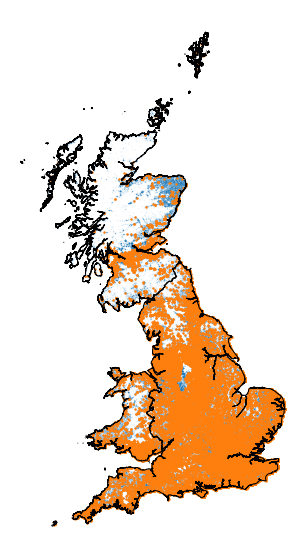

In [36]:
plt.figure()
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(10, 10)
loc_data_geo.plot(ax=ax, markersize=2)
geo_pcu.plot(ax=ax, alpha=0.05, markersize=0.1)
gb_boundary.boundary.plot(color='black', linewidth=1, ax=ax)
ax.axis('off');

In [37]:
fig.savefig('point_output.png', dpi = 300)

## <font color = 'green'> Closet Relation

In [45]:
# kdtree will make this fast
from scipy.spatial import cKDTree

In [46]:
# reference points = imported geo data 
ref_points = np.array([(p.x, p.y) for p in list(loc_data_geo.geometry)])
# other points = ONSPD data centroids
other_points = np.array([(p.x, p.y) for p in list(geo_pcu.geometry)])

In [47]:
print(len(ref_points))
print(len(other_points))

51021
2589831


In [48]:
# initialise trees
kdtree1 = cKDTree(ref_points)
kdtree2 = cKDTree(other_points)

In [49]:
# test at one 1 km radius (BNG measured in 1m units)
indexes = kdtree2.query_ball_tree(kdtree1, r=1000.0)

In [50]:
cKDTree.count_neighbors

<method 'count_neighbors' of 'scipy.spatial.ckdtree.cKDTree' objects>

## <font color ='green'> Weighted Counts

In [51]:
from tqdm import tqdm

<font color = 'red'> **WARNING: When setting radii below please take into account size of ref dataset & max radii size. The larger a dataset the smaller the radii.**

In [52]:
# radii in 1km circles from 1km - Xkm
R = 4e3
radii = list(np.linspace(1e3, R, 4))

In [53]:
# list to store results
counts_list = []

# loop through radii and query trees
for r in tqdm(radii):
    
    indexes = kdtree2.query_ball_tree(kdtree1, r=r)
    
    # count stations within radius r
    counts = np.array([*map(len, indexes)])
    
    # weight with linear weighting function
    counts = counts * (R - r) / R
    
    # store result for that radius
    counts_list.append(counts)

# take mean of the weighted counts to get one feature
weighted_counts = np.array(counts_list).mean(axis=0)

100%|██████████| 4/4 [01:05<00:00, 16.46s/it]


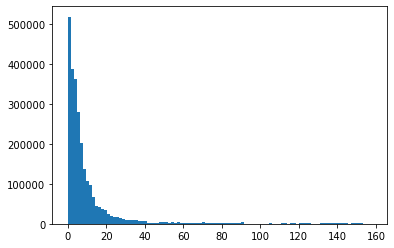

In [54]:
plt.hist(weighted_counts, bins=100);

<font color = 'blue'> Generate dataframe from result

In [55]:
wc_df = pd.DataFrame()
wc_df['pcds'] = geo_pcu['pcds']
wc_df['weighted_counts'] = weighted_counts

In [56]:
wc_df

,pcds,weighted_counts
0,AB1 0AA,0.8125
1,AB1 0AB,0.7500
2,AB1 0AD,0.9375
3,AB1 0AE,0.7500
4,AB1 0AF,1.5000
...,...,...
2673013,ZE3 9JW,0.0000
2673014,ZE3 9JX,0.0000
2673015,ZE3 9JY,0.0000
2673016,ZE3 9JZ,0.0000


## <font color = 'green'> Closest K imported data to postcode & distance to K point

<font color = 'blue'> closest point (imported data) to postcode (ONSPD data)
    
<font color = 'blue'>    Distance in m (BNG measured in 1m units)

<font color = 'blue'> BNG measured in 1m units

In [57]:
kdtree = cKDTree(ref_points)

In [58]:
distances, index = kdtree.query(other_points, k=1)

In [59]:
geo_pcu['ref_index'] = index

In [60]:
geo_pcu['distances_to_ref (m)'] = distances.round(2)

<font color = 'blue'> Add ref postcode to df

In [61]:
loc_postcodes = list(loc_data_geo.Postcode.values)
loc_postcodes.append('')
nearest_loc_pcus = [loc_postcodes[i] for i in index]

In [63]:
geo_pcu['ref_pcu'] = nearest_loc_pcus
geo_pcu

,pcds,doterm,oseast1m,osnrth1m,ctry,ru11ind,geometry,Area,ref_index,distances_to_ref (m),ref_pcu
0,AB1 0AA,199606.0,385386.0,801193.0,S92000003,3,POINT (385386.000 801193.000),AB,124,1167.05,AB14 0QD
1,AB1 0AB,199606.0,385177.0,801314.0,S92000003,3,POINT (385177.000 801314.000),AB,124,1040.62,AB14 0QD
2,AB1 0AD,199606.0,385053.0,801092.0,S92000003,3,POINT (385053.000 801092.000),AB,124,822.05,AB14 0QD
3,AB1 0AE,199606.0,384600.0,799300.0,S92000003,6,POINT (384600.000 799300.000),AB,124,1462.44,AB14 0QD
4,AB1 0AF,199207.0,384460.0,800660.0,S92000003,3,POINT (384460.000 800660.000),AB,124,164.58,AB14 0QD
...,...,...,...,...,...,...,...,...,...,...,...
2673013,ZE3 9JW,NaN,438975.0,1110038.0,S92000003,8,POINT (438975.000 1110038.000),ZE,51012,14451.04,ZE2 9HW
2673014,ZE3 9JX,NaN,438872.0,1110219.0,S92000003,8,POINT (438872.000 1110219.000),ZE,51012,14307.23,ZE2 9HW
2673015,ZE3 9JY,NaN,438498.0,1112029.0,S92000003,8,POINT (438498.000 1112029.000),ZE,51012,12716.41,ZE2 9HW
2673016,ZE3 9JZ,NaN,438662.0,1112122.0,S92000003,8,POINT (438662.000 1112122.000),ZE,51012,12571.42,ZE2 9HW


## <font color = 'green'> Count within radius of postcode centroid

<font color = 'blue'> Find centroids of the ONSP postcodes with a buffer & make into a GeoDf

In [64]:
# Make an empty DF and add postcodes for reference
Count_df = pd.DataFrame()
Count_df['pcds'] = geo_pcu['pcds']

In [65]:
# Amend distance field below to change size of buffer - in meters
distance = 500

In [66]:
Count_df['geometry'] = geo_pcu.centroid.buffer(distance)

In [67]:
Count_df = gpd.GeoDataFrame(Count_df)

In [68]:
Count_df = Count_df.set_geometry('geometry')

<font color = 'blue'> Count referenced location data within specified buffer

In [69]:
data_merged = gpd.sjoin(Count_df, loc_data_geo, how="inner", predicate='intersects')
data_merged

,pcds,geometry,index_right,fsa_id,name,Address,Postcode,easting,northing,lat,long,local_authority
4,AB1 0AF,"POLYGON ((384960.000 800660.000, 384957.592 80...",124,464931,CULTER MILLS SPORTS & SOCIAL CLUB,"Cairn Road, Peterculter, Aberdeen",AB14 0QD,384313,800734,57.097315,-2.260537,Aberdeen City
5,AB1 0AG,"POLYGON ((384390.000 800710.000, 384387.592 80...",124,464931,CULTER MILLS SPORTS & SOCIAL CLUB,"Cairn Road, Peterculter, Aberdeen",AB14 0QD,384313,800734,57.097315,-2.260537,Aberdeen City
97,AB1 0LJ,"POLYGON ((384641.000 800394.000, 384638.592 80...",124,464931,CULTER MILLS SPORTS & SOCIAL CLUB,"Cairn Road, Peterculter, Aberdeen",AB14 0QD,384313,800734,57.097315,-2.260537,Aberdeen City
109,AB1 0NE,"POLYGON ((384943.000 801205.000, 384940.592 80...",124,464931,CULTER MILLS SPORTS & SOCIAL CLUB,"Cairn Road, Peterculter, Aberdeen",AB14 0QD,384313,800734,57.097315,-2.260537,Aberdeen City
130,AB1 0PS,"POLYGON ((384600.000 800580.000, 384597.592 80...",124,464931,CULTER MILLS SPORTS & SOCIAL CLUB,"Cairn Road, Peterculter, Aberdeen",AB14 0QD,384313,800734,57.097315,-2.260537,Aberdeen City
...,...,...,...,...,...,...,...,...,...,...,...,...
2672929,ZE2 9TG,"POLYGON ((445684.000 1175507.000, 445681.592 1...",51019,508000,Welcome Inn,"Mossbank, Shetland",ZE2 9RA,445189,1175437,60.460162,-1.180242,Shetland Islands
2672930,ZE2 9TH,"POLYGON ((445711.000 1175373.000, 445708.592 1...",51019,508000,Welcome Inn,"Mossbank, Shetland",ZE2 9RA,445189,1175437,60.460162,-1.180242,Shetland Islands
2672935,ZE2 9TQ,"POLYGON ((445652.000 1175434.000, 445649.592 1...",51019,508000,Welcome Inn,"Mossbank, Shetland",ZE2 9RA,445189,1175437,60.460162,-1.180242,Shetland Islands
2672905,ZE2 9SB,"POLYGON ((442949.000 1144102.000, 442946.592 1...",51020,507925,Shetland Golf Club,"Dale, Tingwall, Shetland",ZE2 9SB,442448,1144103,60.179150,-1.236662,Shetland Islands


In [70]:
data_merged.groupby('pcds').agg('count')

,geometry,index_right,fsa_id,name,Address,Postcode,easting,northing,lat,long,local_authority
pcds,,,,,,,,,,,
AB1 0AF,1,1,1,1,1,1,1,1,1,1,1
AB1 0AG,4,4,4,4,4,4,4,4,4,4,4
AB1 0LA,1,1,1,1,1,1,1,1,1,1,1
AB1 0LE,3,3,3,3,3,3,3,3,3,3,3
AB1 0LJ,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...
ZE2 9YG,6,6,6,6,6,6,6,6,6,6,6
ZE2 9YH,6,6,6,6,6,6,6,6,6,6,6
ZE2 9YJ,6,6,6,6,6,6,6,6,6,6,6


In [71]:
Count = data_merged.groupby(['pcds'], as_index=False)['fsa_id'].count()
Count.columns = ['pcds','count_ref_loc_within_radius']
Count

,pcds,count_ref_loc_within_radius
0,AB1 0AF,1
1,AB1 0AG,4
2,AB1 0LA,1
3,AB1 0LE,3
4,AB1 0LJ,4
...,...,...
1725016,ZE2 9YG,6
1725017,ZE2 9YH,6
1725018,ZE2 9YJ,6
1725019,ZE2 9YN,6


<font color = 'blue'> Merge count dataframe onto previously created distance dataframe

In [72]:
ref_data = geo_pcu.merge(Count, on=['pcds','pcds'], how='left')
ref_data

,pcds,doterm,oseast1m,osnrth1m,ctry,ru11ind,geometry,Area,ref_index,distances_to_ref (m),ref_pcu,count_ref_loc_within_radius
0,AB1 0AA,199606.0,385386.0,801193.0,S92000003,3,POINT (385386.000 801193.000),AB,124,1167.05,AB14 0QD,NaN
1,AB1 0AB,199606.0,385177.0,801314.0,S92000003,3,POINT (385177.000 801314.000),AB,124,1040.62,AB14 0QD,NaN
2,AB1 0AD,199606.0,385053.0,801092.0,S92000003,3,POINT (385053.000 801092.000),AB,124,822.05,AB14 0QD,NaN
3,AB1 0AE,199606.0,384600.0,799300.0,S92000003,6,POINT (384600.000 799300.000),AB,124,1462.44,AB14 0QD,NaN
4,AB1 0AF,199207.0,384460.0,800660.0,S92000003,3,POINT (384460.000 800660.000),AB,124,164.58,AB14 0QD,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2589826,ZE3 9JW,NaN,438975.0,1110038.0,S92000003,8,POINT (438975.000 1110038.000),ZE,51012,14451.04,ZE2 9HW,NaN
2589827,ZE3 9JX,NaN,438872.0,1110219.0,S92000003,8,POINT (438872.000 1110219.000),ZE,51012,14307.23,ZE2 9HW,NaN
2589828,ZE3 9JY,NaN,438498.0,1112029.0,S92000003,8,POINT (438498.000 1112029.000),ZE,51012,12716.41,ZE2 9HW,NaN
2589829,ZE3 9JZ,NaN,438662.0,1112122.0,S92000003,8,POINT (438662.000 1112122.000),ZE,51012,12571.42,ZE2 9HW,NaN


<font color = 'blue'> Join weighted counts df to previous summary table and tidy df

In [73]:
output = ref_data.merge(wc_df, on=['pcds','pcds'], how='left')
output = output.drop(columns=['oseast1m','osnrth1m','geometry'])
output

,pcds,doterm,ctry,ru11ind,Area,ref_index,distances_to_ref (m),ref_pcu,count_ref_loc_within_radius,weighted_counts
0,AB1 0AA,199606.0,S92000003,3,AB,124,1167.05,AB14 0QD,NaN,0.8125
1,AB1 0AB,199606.0,S92000003,3,AB,124,1040.62,AB14 0QD,NaN,0.7500
2,AB1 0AD,199606.0,S92000003,3,AB,124,822.05,AB14 0QD,NaN,0.9375
3,AB1 0AE,199606.0,S92000003,6,AB,124,1462.44,AB14 0QD,NaN,0.7500
4,AB1 0AF,199207.0,S92000003,3,AB,124,164.58,AB14 0QD,1.0,1.5000
...,...,...,...,...,...,...,...,...,...,...
2589826,ZE3 9JW,NaN,S92000003,8,ZE,51012,14451.04,ZE2 9HW,NaN,0.0000
2589827,ZE3 9JX,NaN,S92000003,8,ZE,51012,14307.23,ZE2 9HW,NaN,0.0000
2589828,ZE3 9JY,NaN,S92000003,8,ZE,51012,12716.41,ZE2 9HW,NaN,0.0000
2589829,ZE3 9JZ,NaN,S92000003,8,ZE,51012,12571.42,ZE2 9HW,NaN,0.0000


## <font color = 'green'> Save output as CSV

In [74]:
output.to_csv('geo_ref_data.csv', index=False)